# Lambda Rank

You are getting the same 的中率 as the person writing this blog:

https://note.com/dataij/n/n5a6d121b13ab

But the 参考回収率 they write is much higher.

In [1]:
import tempfile

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import shap
import tqdm
import trueskill
from hyperopt import STATUS_OK, SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from tqdm import tqdm

from JapanHorseRaceAnalytics.utilities.base import (
    get_random_seed,
    get_spark_session,
    read_hive_table,
)
from JapanHorseRaceAnalytics.utilities.metrics import kelly_criterion
from JapanHorseRaceAnalytics.utilities.plot import plot_feature_importances
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

japanize_matplotlib.japanize()

In [2]:
spark = get_spark_session()

24/07/15 19:32:08 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.105 instead (on interface en0)
24/07/15 19:32:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/07/15 19:32:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/15 19:32:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
data = read_hive_table(
    table_name="features_20240304_v1",
    schema="jhra_curated",
    spark_session=spark,
    # use_cache=False,
    parse_dates=["meta_発走日時"],
)

rows_before = data.shape[0]
logger.info(f"Original data length: {rows_before}")

# Drop from data where cat_トラック種別 == "障害"
# Keep only horses that have 3 races
# Keep only data from 2000 onwards
data = data[
    # (data["cat_トラック種別"] != "障害")
    (~data["meta_着順"].isna())
    # & (data["meta_異常区分"] == "0")
    # & (data["num_1走前着順"].notnull())
    # & (data["num_2走前着順"].notnull())
    # & (data["num_3走前着順"].notnull())
    # & (data["meta_発走日時"] >= "2000-01-01")
]

rows_after = data.shape[0]
logger.info(
    f"Data length after filtering: {rows_after} (dropped {rows_before - rows_after} rows, {100 * (rows_before - rows_after) / rows_before:.2f}%)"
)

# Interpolate missing values for num_馬体重 (20 instances from 1999 ~ 2017)
data["num_馬体重"] = (
    data.sort_values("meta_発走日時")
    .groupby("meta_血統登録番号")["num_馬体重"]
    .transform(lambda x: x.interpolate(method="linear", limit_direction="both"))
)

data.reset_index(drop=True, inplace=True)
data.head()

{"event": "Read from hive jhra_curated.features_20240304_v1", "level": "info", "timestamp": "2024-03-23T04:29:33.956249Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
24/03/23 13:29:34 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/03/23 13:29:34 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/03/23 13:29:35 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
{"event": "Write to parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240304_v1.snappy.parquet", "level": "info", "timestamp": "2024-03-23T04:29:35.956812Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
24/03/23 13:29:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_2024030

,meta_単勝払戻金,meta_複勝払戻金,meta_レースキー,meta_馬番,meta_血統登録番号,meta_発走日時,meta_単勝的中,meta_単勝オッズ,meta_複勝的中,meta_複勝オッズ,...,cat_3走前休養理由分類コード,num_3走前3着タイム差,cat_トラック種別,num_距離,cat_距離区分,num_入厩何日前逆数,cat_堅実な馬,cat_過去3走中1走訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり
0,0,0,09025206,11,00100027,2002-12-01 12:45:00+09:00,0,38.6,0,4.4,...,None,NaN,芝,1600,マイル,1.0,False,False,False,False
1,0,0,08032303,04,00100027,2003-02-08 10:55:00+09:00,0,39.5,0,11.8,...,None,NaN,ダート,1800,中距離,1.0,False,False,False,False
2,0,0,08032801,14,00100027,2003-02-23 10:00:00+09:00,0,31.0,0,3.7,...,None,NaN,ダート,1800,中距離,1.0,False,False,False,False
3,0,0,09031403,07,00100027,2003-03-09 10:55:00+09:00,0,17.2,0,2.3,...,None,1.4,ダート,1800,中距離,1.0,False,False,False,False
4,0,0,09031701,10,00100027,2003-03-22 10:05:00+09:00,0,20.8,0,2.7,...,None,1.1,ダート,1800,中距離,1.0,False,False,False,False


In [3]:
# Initialize ratings for all horses under each condition, plus an overall rating
conditions = [
    "overall",
    "turf",
    "dirt",
    "sprint",
    "mile",
    "middle_distance",
    "intermediate_distance",
    "long_distance",
    "firm",  # 良
    "good",  # 稍重
    "yielding",  # 重
    "soft",  # 不良
]

# Initialize the TrueSkill environment
env = trueskill.TrueSkill(draw_probability=0)  # Assuming no draws in horse racing

In [4]:
df_sorted = data.sort_values(by=["meta_発走日時", "meta_レースキー"])

horse_ratings = {
    horse_id: {condition: env.create_rating() for condition in conditions}
    for horse_id in df_sorted["meta_血統登録番号"].unique()
}

# Placeholder for ratings at each point in time for each condition, including overall
df_sorted["race_overall_quality"] = pd.NA
for condition in conditions:
    df_sorted[f"rating_{condition}_post_race"] = pd.NA
    df_sorted[f"rating_{condition}_uncertainty_post_race"] = pd.NA


# Function to determine the active conditions for a race, considering overall
def get_active_conditions(row):
    active_conditions = ["overall"]

    if row["cat_トラック種別"] == "芝":
        active_conditions.append("turf")
    elif row["cat_トラック種別"] == "ダート":
        active_conditions.append("dirt")

    if row["cat_距離区分"] == "短距離":
        active_conditions.append("sprint")
    elif row["cat_距離区分"] == "マイル":
        active_conditions.append("mile")
    elif row["cat_距離区分"] == "中距離":
        active_conditions.append("middle_distance")
    elif row["cat_距離区分"] == "中長距離":
        active_conditions.append("intermediate_distance")
    elif row["cat_距離区分"] == "長距離":
        active_conditions.append("long_distance")
    
    if row["cat_馬場状態"] == "良":
        active_conditions.append("firm")
    elif row["cat_馬場状態"] == "稍重":
        active_conditions.append("good")
    elif row["cat_馬場状態"] == "重":
        active_conditions.append("yielding")
    elif row["cat_馬場状態"] == "不良":
        active_conditions.append("soft")

    return active_conditions


# Iterate through races in chronological order
for (_, race_id), race_data in tqdm(df_sorted.groupby(["meta_発走日時", "meta_レースキー"])):
    race_results = race_data.sort_values("meta_着順")
    horse_ids = race_results["meta_血統登録番号"].tolist()

    # Determine active conditions for this race
    active_conditions = get_active_conditions(race_data.iloc[0])

    # Measure race quality
    # 0 means significant disparity in skill levels, 1 means very close match
    horse_groups = [[horse_ratings[horse_id]["overall"]] for horse_id in horse_ids]
    df_sorted.loc[race_results.index, "race_overall_quality"] = env.quality(horse_groups)

    # For each condition (including overall), update and record ratings
    for condition in active_conditions:
        horse_groups = [[horse_ratings[horse_id][condition]] for horse_id in horse_ids]
        # Lower rank number means a better position
        ranks = list(range(len(horse_groups)))

        # Update ratings based on the race outcome for each condition
        updated_ratings = env.rate(horse_groups, ranks=ranks)

        # Apply updates to the horse ratings and DataFrame
        for index, (horse_id, new_rating_group) in zip(race_results.index, zip(horse_ids, updated_ratings)):
            # Update ratings in the horse_ratings dictionary for the current condition
            horse_ratings[horse_id][condition] = new_rating_group[0]

            # Store the updated rating in the DataFrame for the current condition
            df_sorted.at[index, f"rating_{condition}_post_race"] = horse_ratings[horse_id][condition].mu
            df_sorted.at[index, f"rating_{condition}_uncertainty_post_race"] = horse_ratings[horse_id][condition].sigma

# Note: At this point, df_sorted contains the updated post-race ratings for each horse under each condition present in the race, including the overall performance.

100%|██████████| 86237/86237 [43:24<00:00, 33.11it/s]  


In [4]:
# df_sorted.to_parquet(
#     "data/sql_tables/features_20240304_v1_with_ratings.snappy.parquet",
#     index=False,
#     compression="snappy",
# )
df_sorted = pd.read_parquet("data/sql_tables/features_20240304_v1_with_ratings.snappy.parquet")

In [5]:
for condition in tqdm(conditions):
    # Lag the rating_post_race by one row per horse (meta_血統登録番号) chronologically (meta_発走日時)
    df_sorted[f"rating_{condition}_pre_race"] = (
        df_sorted.sort_values("meta_発走日時")
        .groupby("meta_血統登録番号")[f"rating_{condition}_post_race"]
        .shift(1)
        .fillna(env.mu)
    )

    df_sorted[f"rating_{condition}_uncertainty_pre_race"] = (
        df_sorted.sort_values("meta_発走日時")
        .groupby("meta_血統登録番号")[f"rating_{condition}_uncertainty_post_race"]
        .shift(1)
        .fillna(env.sigma)
    )

# Now we have pre_race ratings and uncertainties for each horse under each condition, including overall

100%|██████████| 12/12 [00:20<00:00,  1.68s/it]


In [6]:
#
# DISTANCE
#

distance_conditions = [
    df_sorted["cat_距離区分"] == "短距離",
    df_sorted["cat_距離区分"] == "マイル",
    df_sorted["cat_距離区分"] == "中距離",
    df_sorted["cat_距離区分"] == "中長距離",
    df_sorted["cat_距離区分"] == "長距離",
]

distance_choices = [
    df_sorted["rating_sprint_pre_race"],
    df_sorted["rating_mile_pre_race"],
    df_sorted["rating_middle_distance_pre_race"],
    df_sorted["rating_intermediate_distance_pre_race"],
    df_sorted["rating_long_distance_pre_race"],
]

distance_uncertainty_choices = [
    df_sorted["rating_sprint_uncertainty_pre_race"],
    df_sorted["rating_mile_uncertainty_pre_race"],
    df_sorted["rating_middle_distance_uncertainty_pre_race"],
    df_sorted["rating_intermediate_distance_uncertainty_pre_race"],
    df_sorted["rating_long_distance_uncertainty_pre_race"],
]

df_sorted["rating_距離区分_pre_race"] = np.select(distance_conditions, distance_choices, default=np.nan)
df_sorted["rating_距離区分_uncertainty_pre_race"] = np.select(distance_conditions, distance_uncertainty_choices, default=np.nan)

#
# SURFACE TYPE
#

turf_conditions = [
    df_sorted["cat_トラック種別"] == "芝",
    df_sorted["cat_トラック種別"] == "ダート",
]

turf_choices = [
    df_sorted["rating_turf_pre_race"],
    df_sorted["rating_dirt_pre_race"],
]

turf_uncertainty_choices = [
    df_sorted["rating_turf_uncertainty_pre_race"],
    df_sorted["rating_dirt_uncertainty_pre_race"],
]

df_sorted["rating_トラック種別_pre_race"] = np.select(turf_conditions, turf_choices, default=np.nan)
df_sorted["rating_トラック種別_uncertainty_pre_race"] = np.select(turf_conditions, turf_uncertainty_choices, default=np.nan)

#
# GOING
#

going_conditions = [
    df_sorted["cat_馬場状態"] == "良",
    df_sorted["cat_馬場状態"] == "稍重",
    df_sorted["cat_馬場状態"] == "重",
    df_sorted["cat_馬場状態"] == "不良",
]

going_choices = [
    df_sorted["rating_firm_pre_race"],
    df_sorted["rating_good_pre_race"],
    df_sorted["rating_yielding_pre_race"],
    df_sorted["rating_soft_pre_race"],
]

going_uncertainty_choices = [
    df_sorted["rating_firm_uncertainty_pre_race"],
    df_sorted["rating_good_uncertainty_pre_race"],
    df_sorted["rating_yielding_uncertainty_pre_race"],
    df_sorted["rating_soft_uncertainty_pre_race"],
]

df_sorted["rating_馬場状態_pre_race"] = np.select(going_conditions, going_choices, default=np.nan)
df_sorted["rating_馬場状態_uncertainty_pre_race"] = np.select(going_conditions, going_uncertainty_choices, default=np.nan)

#
# MEAN DIFFS
#

for category in ["overall", "距離区分", "トラック種別", "馬場状態"]:
    race_rating_sum = df_sorted.groupby("meta_レースキー")[f"rating_{category}_pre_race"].transform("sum")
    race_horse_count = df_sorted.groupby("meta_レースキー")[f"rating_{category}_pre_race"].transform("count")
    df_sorted[f"mean_competitor_rating_{category}_pre_race"] = (race_rating_sum - df_sorted[f"rating_{category}_pre_race"]) / (race_horse_count - 1)
    df_sorted[f"mean_competitor_rating_{category}_pre_race_diff"] = df_sorted[f"rating_{category}_pre_race"] - df_sorted[f"mean_competitor_rating_{category}_pre_race"]

    race_rating_uncertainty_sum = df_sorted.groupby("meta_レースキー")[f"rating_{category}_uncertainty_pre_race"].transform("sum")
    race_horse_count = df_sorted.groupby("meta_レースキー")[f"rating_{category}_uncertainty_pre_race"].transform("count")
    df_sorted[f"mean_competitor_rating_{category}_uncertainty_pre_race"] = (race_rating_uncertainty_sum - df_sorted[f"rating_{category}_uncertainty_pre_race"]) / (race_horse_count - 1)
    df_sorted[f"mean_competitor_rating_{category}_uncertainty_pre_race_diff"] = df_sorted[f"rating_{category}_uncertainty_pre_race"] - df_sorted[f"mean_competitor_rating_{category}_uncertainty_pre_race"]

# Use the following columns as features
# rating_{category}_pre_race
# rating_{category}_uncertainty_pre_race
# mean_competitor_rating_{category}_pre_race_diff
# mean_competitor_rating_{category}_uncertainty_pre_race_diff


# Looks good
df_sorted[
    [
        "cat_トラック種別",
        "rating_turf_pre_race",
        "rating_turf_uncertainty_pre_race",
        "rating_dirt_pre_race",
        "rating_dirt_uncertainty_pre_race",
        "rating_トラック種別_pre_race",
        "rating_トラック種別_uncertainty_pre_race",
        "mean_competitor_rating_トラック種別_pre_race_diff",
        "mean_competitor_rating_トラック種別_uncertainty_pre_race_diff",
    ]
].sample(10)

,cat_トラック種別,rating_turf_pre_race,rating_turf_uncertainty_pre_race,rating_dirt_pre_race,rating_dirt_uncertainty_pre_race,rating_トラック種別_pre_race,rating_トラック種別_uncertainty_pre_race,mean_competitor_rating_トラック種別_pre_race_diff,mean_competitor_rating_トラック種別_uncertainty_pre_race_diff
380345,芝,25.000000,8.333333,25.000000,8.333333,25.000000,8.333333,0.000000,0.000000
51260,障害,25.000000,8.333333,27.254436,1.505534,NaN,NaN,NaN,NaN
549885,芝,20.719079,3.106922,25.000000,8.333333,20.719079,3.106922,-3.438934,-1.752582
133967,芝,25.000000,8.333333,25.000000,8.333333,25.000000,8.333333,0.671282,0.235216
61791,芝,30.640367,1.534956,25.000000,8.333333,30.640367,1.534956,1.813944,-1.066690
4487,ダート,25.000000,8.333333,29.758665,4.297199,29.758665,4.297199,1.692353,-2.175848
851671,ダート,25.000000,8.333333,20.015312,3.424001,20.015312,3.424001,-4.713358,-1.738532
1157568,ダート,27.438983,2.321626,25.000000,8.333333,25.000000,8.333333,-4.878492,6.820505
996083,ダート,25.000000,8.333333,27.592864,1.809559,27.592864,1.809559,-0.067589,-1.349294
789610,障害,25.000000,8.333333,25.000000,8.333333,NaN,NaN,NaN,NaN


In [7]:
# Calculate the average 1走前経過日数 for each horse's competitors in the same race, excluding the horse itself. Store in "mean_competitor_1走前経過日数" column.
race_sums = df_sorted.groupby('meta_レースキー')['num_1走前経過日数'].transform('sum')
race_counts = df_sorted.groupby('meta_レースキー')['num_1走前経過日数'].transform('count')
# Calculate the average for competitors of each horse
df_sorted['mean_competitor_1走前経過日数'] = (race_sums - df_sorted['num_1走前経過日数']) / (race_counts - 1)

In [8]:
df_final = df_sorted[
    (df_sorted["cat_トラック種別"] != "障害")
    # & (df_sorted["num_1走前着順"].notnull())
    # & (df_sorted["num_2走前着順"].notnull())
    # & (df_sorted["num_3走前着順"].notnull())
    # & (df_sorted["num_平均馬体重差"].notnull())  # only 7 records, handle later
    # & (df_sorted["mean_competitor_1走前経過日数"].notnull())  # 1 row
]

In [9]:
df = df_final.copy()

# 1. Weighted average position
df["num_1走前標準化着順"] = (df["num_1走前着順"] - 1) / (df["num_1走前頭数"] - 1)
df["num_2走前標準化着順"] = (df["num_2走前着順"] - 1) / (df["num_2走前頭数"] - 1)
df["num_3走前標準化着順"] = (df["num_3走前着順"] - 1) / (df["num_3走前頭数"] - 1)
# We want our factor (num_1走前経過日数) to start from 0
# so subtract the minimum value for "days since last race" across all horses
# Add a small number to avoid division by zero
df["num_1走前重み"] = 1 / (df["num_1走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
df["num_2走前重み"] = 1 / (df["num_2走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
df["num_3走前重み"] = 1 / (df["num_3走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
# Calculate weighted average of the feature
df["num_過去3走重み付き標準化着順"] = (
    (df["num_1走前標準化着順"] * df["num_1走前重み"])
    + (df["num_2走前標準化着順"] * df["num_2走前重み"])
    + (df["num_3走前標準化着順"] * df["num_3走前重み"])
) / (df["num_1走前重み"] + df["num_2走前重み"] + df["num_3走前重み"])

# 2. Weighted average time difference between the horse and the 3 horses behind it
df["num_1走前後続馬平均タイム差"] = (
    df[["num_1走前後続馬1タイム差", "num_1走前後続馬2タイム差", "num_1走前後続馬3タイム差"]]
    .mean(axis=1)
    .fillna(0)
)
df["num_2走前後続馬平均タイム差"] = (
    df[["num_2走前後続馬1タイム差", "num_2走前後続馬2タイム差", "num_2走前後続馬3タイム差"]]
    .mean(axis=1)
    .fillna(0)
)
df["num_3走前後続馬平均タイム差"] = (
    df[["num_3走前後続馬1タイム差", "num_3走前後続馬2タイム差", "num_3走前後続馬3タイム差"]]
    .mean(axis=1)
    .fillna(0)
)
df["num_過去3走重み付き後続馬平均タイム差"] = (
    (df["num_1走前後続馬平均タイム差"] * df["num_1走前重み"])
    + (df["num_2走前後続馬平均タイム差"] * df["num_2走前重み"])
    + (df["num_3走前後続馬平均タイム差"] * df["num_3走前重み"])
) / (df["num_1走前重み"] + df["num_2走前重み"] + df["num_3走前重み"])

In [10]:
# Get the average of "rating_距離区分_pre_race", "rating_トラック種別_pre_race", "rating_馬場状態_pre_race" for each row in df and store it as a new column "foo"
df["rating_適性_pre_race"] = df[
    [
        "rating_距離区分_pre_race",
        "rating_トラック種別_pre_race",
        "rating_馬場状態_pre_race",
    ]
].mean(axis=1)

df["mean_competitor_rating_適性_pre_race_diff"] = df[
    [
        "mean_competitor_rating_距離区分_pre_race_diff",
        "mean_competitor_rating_トラック種別_pre_race_diff",
        "mean_competitor_rating_馬場状態_pre_race_diff",
    ]
].mean(axis=1)

In [11]:
# Initialize GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=get_random_seed())

# Assume df['group'] is your grouping variable
# Splitting the data
for train_idx, test_idx in gss.split(df, groups=df["meta_レースキー"]):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

# Now, train_df and test_df contain your split data, respecting group boundaries
X_train = train_df
y_train = train_df["meta_着順"].apply(lambda x: int(1.0 / x * 10) if x < 4 else 0)

group_counts_train = X_train.groupby('meta_レースキー').size().reset_index(name='レースキー_count')
first_occurrences_train = X_train[['meta_レースキー']].drop_duplicates().reset_index(drop=True)
merged_train = first_occurrences_train.merge(group_counts_train, on='meta_レースキー', how='left')
groups_train = merged_train["レースキー_count"].values

X_test = test_df
y_test = test_df["meta_着順"].apply(lambda x: int(1.0 / x * 10) if x < 4 else 0)

group_counts_test = X_test.groupby('meta_レースキー').size().reset_index(name='レースキー_count')
first_occurrences_train = X_test[['meta_レースキー']].drop_duplicates().reset_index(drop=True)
merged_test = first_occurrences_train.merge(group_counts_test, on='meta_レースキー', how='left')
groups_test = merged_test["レースキー_count"].values

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"groups_train: {groups_train.shape}")
print(f"groups_test: {groups_test.shape}")

X_train: (934708, 202)
X_test: (233279, 202)
y_train: (934708,)
y_test: (233279,)
groups_train: (66386,)
groups_test: (16597,)


In [12]:
def calculate_average_ndcg(model, valid_dataset) -> float:
    y_pred = model.predict(valid_dataset.data)

    ## Initialize an empty list to store the NDCG scores of each group
    ndcg_scores = []
    # The starting index of the first item in the current group
    start_idx = 0
    for group_size in valid_dataset.group:
        end_idx = start_idx + group_size
        # Slice the true labels and predictions according to the current group
        true_labels = valid_dataset.label[start_idx:end_idx]
        predictions = y_pred[start_idx:end_idx]

        # Calculate the NDCG score for the current group.
        # ndcg_score expects 2D arrays, so we add an extra dimension
        ndcg = ndcg_score([true_labels], [predictions])
        ndcg_scores.append(ndcg)

        # Update the start index for the next group
        start_idx = end_idx

    # Calculate the average NDCG score across all groups
    return np.mean(ndcg_scores)


def create_objective_fn(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    groups_train: np.ndarray,
    groups_test: np.ndarray,
    experiment_name: str,
):
    def objective(params):
        mlflow.set_experiment(experiment_name=experiment_name)
        with mlflow.start_run():
            preprocessor = ColumnTransformer(
                transformers=[
                    (
                        "ord",
                        OrdinalEncoder(categories=[["良", "稍重", "重", "不良"]]),
                        ["cat_馬場状態"],
                    ),
                    (
                        "cat",
                        OneHotEncoder(drop="if_binary"),
                        ["cat_トラック種別", "cat_性別"],
                    ),
                    (
                        "num",
                        StandardScaler(),
                        [
                            "num_馬体重",
                            "num_頭数",
                            "num_負担重量",
                            "num_年齢",
                            "num_距離",
                            "num_平均馬体重差",
                            # "num_複勝率",
                            "num_1走前経過日数",
                            "mean_competitor_1走前経過日数",
                            "num_過去3走重み付き標準化着順",
                            "num_過去3走重み付き後続馬平均タイム差",
                            "race_overall_quality",
                            "rating_overall_uncertainty_pre_race",
                            "mean_competitor_rating_overall_pre_race_diff",
                        ],
                    ),
                ],
                remainder="drop",
                verbose_feature_names_out=False,
            )

            X_train_prep = preprocessor.fit_transform(X_train)
            X_test_prep = preprocessor.transform(X_test)

            feature_names = preprocessor.get_feature_names_out().tolist()
            categorical_features = [
                *preprocessor.named_transformers_["ord"]
                .get_feature_names_out()
                .tolist(),
                *preprocessor.named_transformers_["cat"]
                .get_feature_names_out()
                .tolist(),
            ]

            train_dataset = lgb.Dataset(
                X_train_prep,
                label=y_train,
                group=groups_train,
                feature_name=feature_names,
                categorical_feature=categorical_features,
            )
            valid_dataset = lgb.Dataset(
                data=X_test_prep,
                label=y_test,
                group=groups_test,
                reference=train_dataset,
                free_raw_data=False,
                feature_name=feature_names,
                categorical_feature=categorical_features,
            )
            model = lgb.train(
                params,
                train_dataset,
                valid_sets=[valid_dataset],
                num_boost_round=1000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50),
                ],
            )

            # 1 means perfect ranking, 0 means worst ranking
            average_ndcg = calculate_average_ndcg(model, valid_dataset)
            loss = -average_ndcg

            mlflow.log_params(params)
            mlflow.log_metric("loss", loss)
            mlflow.log_metric("average_ndcg", average_ndcg)

            # Tree Plot
            ax = lgb.plot_tree(model, figsize=(20, 20), show_info=["split_gain", "data_percentage"], precision=2)
            fig = ax.get_figure()
            with tempfile.NamedTemporaryFile(
                prefix="lgbm_tree_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Plot (Gain)
            fig, ax = plot_feature_importances(
                feature_names=preprocessor.get_feature_names_out(),
                feature_importances=model.feature_importance(importance_type="gain"),
                top_n=50,
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_gain_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Data (Gain)
            feature_importances = zip(
                preprocessor.get_feature_names_out(),
                model.feature_importance(importance_type="gain"),
            )
            feature_importances_df = (
                pd.DataFrame(feature_importances, columns=["feature", "importance"])
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_gain_", suffix=".csv"
            ) as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # Feature Importances Plot (Split)
            fig, ax = plot_feature_importances(
                feature_names=preprocessor.get_feature_names_out(),
                feature_importances=model.feature_importance(importance_type="split"),
                top_n=50,
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_split_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Data (Split)
            feature_importances = zip(
                preprocessor.get_feature_names_out(),
                model.feature_importance(importance_type="split"),
            )
            feature_importances_df = (
                pd.DataFrame(feature_importances, columns=["feature", "importance"])
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_split_", suffix=".csv"
            ) as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # SHAP values
            X_test_sample = X_test.sample(n=5000, random_state=get_random_seed())
            X_test_sample_prep = preprocessor.transform(X_test_sample)
            explainer = shap.TreeExplainer(
                model=model,
                feature_names=preprocessor.get_feature_names_out(),
            )
            shap_values = explainer(X_test_sample_prep)

            # Takes a long time
            # shap_interaction_values = explainer.shap_interaction_values(X_test_sample_prep)

            # SHAP beeswarm plot
            shap.plots.beeswarm(shap_values, show=False, max_display=25)
            plt.tight_layout()
            with tempfile.NamedTemporaryFile(
                prefix="shap_beeswarm_", suffix=".png"
            ) as f:
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # SHAP interaction values heatmap
            # fig, ax = plot_shap_interaction_values(
            #     shap_interaction_values, preprocessor.get_feature_names_out()
            # )
            # with tempfile.NamedTemporaryFile(
            #     prefix="shap_interactions_", suffix=".png"
            # ) as f:
            #     fig.savefig(f.name)
            #     plt.close()
            #     mlflow.log_artifact(f.name)

            # SHAP bar plot
            shap.plots.bar(shap_values, show=False, max_display=25)
            plt.tight_layout()
            with tempfile.NamedTemporaryFile(prefix="shap_bar_", suffix=".png") as f:
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            return {"loss": loss, "params": params, "status": STATUS_OK}

    return objective

In [13]:
space = {
    "num_leaves": scope.int(hp.quniform("num_leaves", 20, 150, 1)),
    "learning_rate": hp.loguniform("learning_rate", -5, 0),  # between e^-5 and 1
    "min_data_in_leaf": hp.choice("min_data_in_leaf", range(20, 100)),
    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "bagging_fraction": hp.uniform("bagging_fraction", 0.5, 1.0),
    "bagging_freq": hp.choice("bagging_freq", range(1, 10)),
    "lambda_l1": hp.uniform("lambda_l1", 0, 10),
    "lambda_l2": hp.uniform("lambda_l2", 0, 10),
    "max_depth": hp.choice("max_depth", range(3, 15)),
    # Constant parameters
    "objective": "lambdarank",
    "metric": ["ndcg", "map"],
    "ndcg_eval_at": [1, 3, 5],
    "verbose": -1,
    "seed": get_random_seed(),
    "boosting_type": "gbdt",
}

In [18]:
payouts = (
    X_test[["meta_発走日時", "meta_複勝払戻金", "meta_複勝オッズ"]]
    .reset_index(drop=True)
    .rename(
        columns={
            "meta_発走日時": "発走日時",
            "meta_複勝払戻金": "payout",
            "meta_複勝オッズ": "odds",
        }
    )
    .assign(発走日時=lambda x: pd.to_datetime(x["発走日時"]))
)

experiment_name = "20240322-lambda-fixed"

if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name)

fn = create_objective_fn(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups_train=groups_train,
    groups_test=groups_test,
    experiment_name=experiment_name,
)

In [19]:
# trials = Trials()
# fmin(
#     fn=fn,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=1,
#     trials=trials,
# )

trials = SparkTrials(parallelism=3, spark_session=spark)
fmin(fn=fn, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.003599 seconds
TPE using 0 trials
build_posterior_wrapper took 0.042706 seconds
TPE using 1/1 trials with best loss inf
build_posterior_wrapper took 0.002388 seconds
TPE using 2/2 trials with best loss inf
build_posterior_wrapper took 0.002487 seconds
TPE using 3/3 trials with best loss inf
Training until validation scores don't improve for 50 rounds:>    (0 + 1) / 1]1]
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's ndcg@1: 0.262812	valid_0's ndcg@3: 0.42031	valid_0's ndcg@5: 0.495698	valid_0's map@1: 0.549015	valid_0's map@3: 0.37006	valid_0's map@5: 0.466279
Early stopping, best iteration is:
[45]	valid_0's ndcg@1: 0.269284	valid_0's ndcg@3: 0.429199	valid_0's ndcg@5: 0.502549	valid_0's map@1: 0.55275	valid_0's map@3: 0.373903	valid_0's map@5: 0.471043
Closing down clientserver connection                                           

  3%|▎         | 1/30 [00:35<16:55, 35.03s/trial, best loss: -0.6755649519276402]

build_posterior_wrapper took 0.004146 seconds
TPE using 4/4 trials with best loss -0.675565
Closing down clientserver connection                                            


  7%|▋         | 2/30 [00:37<07:21, 15.76s/trial, best loss: -0.6755649519276402]

build_posterior_wrapper took 0.002794 seconds
TPE using 5/5 trials with best loss -0.675565
Training until validation scores don't improve for 50 rounds:>    (0 + 1) / 1]1]
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[268]	valid_0's ndcg@1: 0.263906	valid_0's ndcg@3: 0.42469	valid_0's ndcg@5: 0.498633	valid_0's map@1: 0.548894	valid_0's map@3: 0.373478	valid_0's map@5: 0.469988
Closing down clientserver connection                                            


 10%|█         | 3/30 [01:01<08:55, 19.83s/trial, best loss: -0.6755649519276402]

build_posterior_wrapper took 0.003634 secondse 4:>                  (0 + 1) / 1]
TPE using 6/6 trials with best loss -0.675565
Early stopping, best iteration is:
[24]	valid_0's ndcg@1: 0.26743	valid_0's ndcg@3: 0.425794	valid_0's ndcg@5: 0.500449	valid_0's map@1: 0.553353	valid_0's map@3: 0.375339	valid_0's map@5: 0.471493
Early stopping, best iteration is::>    (0 + 1) / 1][Stage 5:>    (0 + 1) / 1]
[70]	valid_0's ndcg@1: 0.268182	valid_0's ndcg@3: 0.427117	valid_0's ndcg@5: 0.502639	valid_0's map@1: 0.552329	valid_0's map@3: 0.373689	valid_0's map@5: 0.471114
Closing down clientserver connection                                            


 13%|█▎        | 4/30 [01:13<07:10, 16.56s/trial, best loss: -0.6755649519276402]

build_posterior_wrapper took 0.002602 seconds
TPE using 7/7 trials with best loss -0.675565
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 17%|█▋        | 5/30 [01:19<05:20, 12.83s/trial, best loss: -0.6755649519276402]

build_posterior_wrapper took 0.002693 secondse 6:>                  (0 + 1) / 1]
TPE using 8/8 trials with best loss -0.675565
Early stopping, best iteration is:
[62]	valid_0's ndcg@1: 0.265249	valid_0's ndcg@3: 0.426176	valid_0's ndcg@5: 0.500125	valid_0's map@1: 0.552268	valid_0's map@3: 0.374013	valid_0's map@5: 0.471385
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 20%|██        | 6/30 [01:29<04:43, 11.80s/trial, best loss: -0.6755649519276402]

build_posterior_wrapper took 0.003078 seconds
TPE using 9/9 trials with best loss -0.675565
Training until validation scores don't improve for 50 rounds        (0 + 1) / 1]
Early stopping, best iteration is::>    (0 + 1) / 1][Stage 8:>    (0 + 1) / 1]
[37]	valid_0's ndcg@1: 0.267864	valid_0's ndcg@3: 0.427697	valid_0's ndcg@5: 0.501181	valid_0's map@1: 0.553474	valid_0's map@3: 0.374482	valid_0's map@5: 0.471107
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 23%|██▎       | 7/30 [01:51<05:50, 15.23s/trial, best loss: -0.6755649519276402]

build_posterior_wrapper took 0.002997 secondse 8:>                  (0 + 1) / 1]
TPE using 10/10 trials with best loss -0.675565
Early stopping, best iteration is:
[61]	valid_0's ndcg@1: 0.264881	valid_0's ndcg@3: 0.426892	valid_0's ndcg@5: 0.50152	valid_0's map@1: 0.553895	valid_0's map@3: 0.375841	valid_0's map@5: 0.471938
Early stopping, best iteration is:
[82]	valid_0's ndcg@1: 0.267687	valid_0's ndcg@3: 0.428901	valid_0's ndcg@5: 0.502484	valid_0's map@1: 0.55269	valid_0's map@3: 0.376092	valid_0's map@5: 0.472884
Closing down clientserver connection                                            


 27%|██▋       | 8/30 [02:06<05:27, 14.90s/trial, best loss: -0.6757830318171727]

Training until validation scores don't improve for 50 rounds        (0 + 1) / 1]
build_posterior_wrapper took 0.003217 seconds
TPE using 11/11 trials with best loss -0.675783
Closing down clientserver connection                                            


 30%|███       | 9/30 [02:08<03:48, 10.89s/trial, best loss: -0.6757830318171727]

build_posterior_wrapper took 0.002399 seconds                       (0 + 1) / 1]
TPE using 12/12 trials with best loss -0.675783
Early stopping, best iteration is:
[8]	valid_0's ndcg@1: 0.261069	valid_0's ndcg@3: 0.420668	valid_0's ndcg@5: 0.493657	valid_0's map@1: 0.542568	valid_0's map@3: 0.367747	valid_0's map@5: 0.462933
Closing down clientserver connection                                            


 33%|███▎      | 10/30 [02:19<03:41, 11.07s/trial, best loss: -0.6757830318171727]

build_posterior_wrapper took 0.005133 seconds
Training until validation scores don't improve for 50 rounds
TPE using 13/13 trials with best loss -0.675783
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:1:>   (0 + 1) / 1][Stage 12:>   (0 + 1) / 1]
[12]	valid_0's ndcg@1: 0.261768	valid_0's ndcg@3: 0.421818	valid_0's ndcg@5: 0.49718	valid_0's map@1: 0.545701	valid_0's map@3: 0.370746	valid_0's map@5: 0.467334
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 37%|███▋      | 11/30 [02:37<04:08, 13.07s/trial, best loss: -0.6757830318171727]

Early stopping, best iteration is:
[98]	valid_0's ndcg@1: 0.269987	valid_0's ndcg@3: 0.43094	valid_0's ndcg@5: 0.504896	valid_0's map@1: 0.554558	valid_0's map@3: 0.376296	valid_0's map@5: 0.472974
build_posterior_wrapper took 0.003025 seconds
TPE using 14/14 trials with best loss -0.67578312:>                 (0 + 1) / 1]
Early stopping, best iteration is:
[7]	valid_0's ndcg@1: 0.259494	valid_0's ndcg@3: 0.418567	valid_0's ndcg@5: 0.49251	valid_0's map@1: 0.543592	valid_0's map@3: 0.365766	valid_0's map@5: 0.461543
Closing down clientserver connection                                            


 40%|████      | 12/30 [02:43<03:17, 10.96s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.003559 secondse 13:>                 (0 + 1) / 1]
TPE using 15/15 trials with best loss -0.676857
Closing down clientserver connection                                            


 43%|████▎     | 13/30 [02:49<02:44,  9.67s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.003496 seconds                       (0 + 1) / 1]
TPE using 16/16 trials with best loss -0.676857
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds5:>   (0 + 1) / 1]1]
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's ndcg@1: 0.265646	valid_0's ndcg@3: 0.426999	valid_0's ndcg@5: 0.500642	valid_0's map@1: 0.552148	valid_0's map@3: 0.374894	valid_0's map@5: 0.469992
Early stopping, best iteration is:
[56]	valid_0's ndcg@1: 0.2654	valid_0's ndcg@3: 0.424864	valid_0's ndcg@5: 0.499998	valid_0's map@1: 0.55269	valid_0's map@3: 0.37472	valid_0's map@5: 0.47101
Closing down clientserver connection                                            


 47%|████▋     | 14/30 [03:18<04:05, 15.33s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.003085 seconds
TPE using 17/17 trials with best loss -0.676857
Early stopping, best iteration is:) / 1][Stage 15:>                 (0 + 1) / 1]
[81]	valid_0's ndcg@1: 0.267901	valid_0's ndcg@3: 0.428382	valid_0's ndcg@5: 0.502854	valid_0's map@1: 0.551124	valid_0's map@3: 0.374582	valid_0's map@5: 0.471574
Closing down clientserver connection                                            


 50%|█████     | 15/30 [03:25<03:12, 12.85s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.003367 seconds
TPE using 18/18 trials with best loss -0.676857                     (0 + 1) / 1]
Closing down clientserver connection                                            


 53%|█████▎    | 16/30 [03:31<02:32, 10.90s/trial, best loss: -0.6768568447039638]

Training until validation scores don't improve for 50 rounds        (0 + 1) / 1]
build_posterior_wrapper took 0.002839 secondse 17:>                 (0 + 1) / 1]
TPE using 19/19 trials with best loss -0.676857
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's ndcg@1: 0.261818	valid_0's ndcg@3: 0.422691	valid_0's ndcg@5: 0.496409	valid_0's map@1: 0.546786	valid_0's map@3: 0.371597	valid_0's map@5: 0.467118
Training until validation scores don't improve for 50 rounds8:>   (0 + 1) / 1]
Closing down clientserver connection                                            
Early stopping, best iteration is:) / 1][Stage 18:>                 (0 + 1) / 1]
[39]	valid_0's ndcg@1: 0.267986	valid_0's ndcg@3: 0.428416	valid_0's ndcg@5: 0.500562	valid_0's map@1: 0.551847	valid_0's map@3: 0.3731	valid_0's map@5: 0.46954


 57%|█████▋    | 17/30 [03:49<02:47, 12.88s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.003164 seconds
TPE using 20/20 trials with best loss -0.676857
Closing down clientserver connection                                            


 60%|██████    | 18/30 [03:53<02:04, 10.38s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.002645 seconds                       (0 + 1) / 1]
TPE using 21/21 trials with best loss -0.676857
Early stopping, best iteration is:) / 1][Stage 19:>                 (0 + 1) / 1]
[13]	valid_0's ndcg@1: 0.262398	valid_0's ndcg@3: 0.424101	valid_0's ndcg@5: 0.496691	valid_0's map@1: 0.547207	valid_0's map@3: 0.372664	valid_0's map@5: 0.467639
Closing down clientserver connection                                            


 63%|██████▎   | 19/30 [04:03<01:50, 10.03s/trial, best loss: -0.6768568447039638]

Training until validation scores don't improve for 50 rounds
build_posterior_wrapper took 0.002918 seconds                       (0 + 1) / 1]
TPE using 22/22 trials with best loss -0.676857
Training until validation scores don't improve for 50 rounds        (0 + 1) / 1]
Early stopping, best iteration is:0:>   (0 + 1) / 1][Stage 21:>   (0 + 1) / 1]
[47]	valid_0's ndcg@1: 0.265114	valid_0's ndcg@3: 0.424755	valid_0's ndcg@5: 0.499807	valid_0's map@1: 0.554498	valid_0's map@3: 0.374117	valid_0's map@5: 0.471201
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's ndcg@1: 0.269015	valid_0's ndcg@3: 0.428687	valid_0's ndcg@5: 0.502985	valid_0's map@1: 0.55269	valid_0's map@3: 0.375068	valid_0's map@5: 0.472449
Closing down clientserver connection                                            


 67%|██████▋   | 20/30 [04:32<02:37, 15.78s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.003086 seconds
Closing down clientserver connection
TPE using 23/23 trials with best loss -0.676857


 70%|███████   | 21/30 [04:33<01:43, 11.53s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.002860 seconds
TPE using 24/24 trials with best loss -0.676857
Early stopping, best iteration is:
[200]	valid_0's ndcg@1: 0.268376	valid_0's ndcg@3: 0.429001	valid_0's ndcg@5: 0.503352	valid_0's map@1: 0.553112	valid_0's map@3: 0.375781	valid_0's map@5: 0.472428
Closing down clientserver connection                                            


 73%|███████▎  | 22/30 [04:59<02:06, 15.86s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.053812 secondse 23:>                 (0 + 1) / 1]
TPE using 25/25 trials with best loss -0.676857
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's ndcg@1: 0.264148	valid_0's ndcg@3: 0.426882	valid_0's ndcg@5: 0.501223	valid_0's map@1: 0.550099	valid_0's map@3: 0.37471	valid_0's map@5: 0.471517
Closing down clientserver connection                                            


 77%|███████▋  | 23/30 [05:19<01:57, 16.85s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.051270 secondse 24:>                 (0 + 1) / 1]
TPE using 26/26 trials with best loss -0.676857
Early stopping, best iteration is:
[84]	valid_0's ndcg@1: 0.267592	valid_0's ndcg@3: 0.427529	valid_0's ndcg@5: 0.502443	valid_0's map@1: 0.553293	valid_0's map@3: 0.37553	valid_0's map@5: 0.472758
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 80%|████████  | 24/30 [05:29<01:29, 14.91s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.002758 seconds
TPE using 27/27 trials with best loss -0.676857
Early stopping, best iteration is:) / 1][Stage 25:>                 (0 + 1) / 1]
[53]	valid_0's ndcg@1: 0.268391	valid_0's ndcg@3: 0.427632	valid_0's ndcg@5: 0.502317	valid_0's map@1: 0.557028	valid_0's map@3: 0.37486	valid_0's map@5: 0.472372
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 83%|████████▎ | 25/30 [05:42<01:11, 14.34s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.080752 seconds
TPE using 28/28 trials with best loss -0.676857
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds7:>   (0 + 1) / 1]
Early stopping, best iteration is:
[246]	valid_0's ndcg@1: 0.26943	valid_0's ndcg@3: 0.43036	valid_0's ndcg@5: 0.503798	valid_0's map@1: 0.554317	valid_0's map@3: 0.376333	valid_0's map@5: 0.473352
Early stopping, best iteration is:
[8]	valid_0's ndcg@1: 0.257263	valid_0's ndcg@3: 0.418267	valid_0's ndcg@5: 0.49114	valid_0's map@1: 0.542688	valid_0's map@3: 0.36763	valid_0's map@5: 0.462364
Closing down clientserver connection                                            


 87%|████████▋ | 26/30 [06:21<01:26, 21.74s/trial, best loss: -0.6768568447039638]

build_posterior_wrapper took 0.004000 seconds
TPE using 29/29 trials with best loss -0.676857
Closing down clientserver connection                                            


 90%|█████████ | 27/30 [06:23<00:47, 15.87s/trial, best loss: -0.6768568447039638]

Early stopping, best iteration is:                                  (0 + 1) / 1]
[235]	valid_0's ndcg@1: 0.268098	valid_0's ndcg@3: 0.429908	valid_0's ndcg@5: 0.503511	valid_0's map@1: 0.55504	valid_0's map@3: 0.377106	valid_0's map@5: 0.474047
Closing down clientserver connection                                            


 93%|█████████▎| 28/30 [06:44<00:34, 17.46s/trial, best loss: -0.6768568447039638]

Training until validation scores don't improve for 50 rounds        (0 + 1) / 1]
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's ndcg@1: 0.268504	valid_0's ndcg@3: 0.429075	valid_0's ndcg@5: 0.502754	valid_0's map@1: 0.55492	valid_0's map@3: 0.374987	valid_0's map@5: 0.471716
Closing down clientserver connection                                            


 97%|█████████▋| 29/30 [07:03<00:17, 17.94s/trial, best loss: -0.6768568447039638]

Early stopping, best iteration is:
[200]	valid_0's ndcg@1: 0.268065	valid_0's ndcg@3: 0.42945	valid_0's ndcg@5: 0.503079	valid_0's map@1: 0.554257	valid_0's map@3: 0.376049	valid_0's map@5: 0.473013
Closing down clientserver connection                                            


100%|██████████| 30/30 [07:24<00:00, 14.83s/trial, best loss: -0.6768568447039638]

Queue empty, exiting run.


Closing down clientserver connection
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.


{'bagging_fraction': 0.9116111690692841,
 'bagging_freq': 0,
 'feature_fraction': 0.781339641466574,
 'lambda_l1': 8.43289033439255,
 'lambda_l2': 9.635918997870911,
 'learning_rate': 0.1369333650610556,
 'max_depth': 11,
 'min_data_in_leaf': 48,
 'num_leaves': 21.0}

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "ord",
            OrdinalEncoder(categories=[["良", "稍重", "重", "不良"]]),
            ["cat_馬場状態"],
        ),
        (
            "cat",
            OneHotEncoder(drop="if_binary"),
            ["cat_トラック種別", "cat_性別"],
        ),
        (
            "num",
            StandardScaler(),
            [
                "num_馬体重",
                "num_頭数",
                "num_負担重量",
                "num_年齢",
                "num_距離",
                "num_平均馬体重差",
                # "num_複勝率",
                "num_1走前経過日数",
                "mean_competitor_1走前経過日数",
                "num_過去3走重み付き標準化着順",
                "num_過去3走重み付き後続馬平均タイム差",
                "race_overall_quality",
                "rating_overall_uncertainty_pre_race",
                "mean_competitor_rating_overall_pre_race_diff",
            ],
        ),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out().tolist()
categorical_features = [
    *preprocessor.named_transformers_["ord"].get_feature_names_out().tolist(),
    *preprocessor.named_transformers_["cat"].get_feature_names_out().tolist(),
]

train_dataset = lgb.Dataset(
    X_train_prep,
    label=y_train,
    group=groups_train,
    feature_name=feature_names,
    categorical_feature=categorical_features,
)
valid_dataset = lgb.Dataset(
    data=X_test_prep,
    label=y_test,
    group=groups_test,
    reference=train_dataset,
    free_raw_data=False,
    feature_name=feature_names,
    categorical_feature=categorical_features,
)
params = {
    "bagging_fraction": 0.9116111690692841,
    "bagging_freq": 0,
    "feature_fraction": 0.781339641466574,
    "lambda_l1": 8.43289033439255,
    "lambda_l2": 9.635918997870911,
    "learning_rate": 0.1369333650610556,
    "max_depth": 11,
    "min_data_in_leaf": 48,
    "num_leaves": 21,
    "ndcg_eval_at": (1, 3, 5),
    "boosting_type": "gbdt",
    "metric": ("ndcg", "map"),
    "objective": "lambdarank",
    "seed": 42,
    "verbose": -1,
}

model = lgb.train(
    params,
    train_dataset,
    valid_sets=[valid_dataset],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
    ],
)
y_pred = model.predict(valid_dataset.data)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's ndcg@1: 0.267159	valid_0's ndcg@3: 0.428048	valid_0's ndcg@5: 0.502774	valid_0's map@1: 0.55257	valid_0's map@3: 0.375617	valid_0's map@5: 0.472413


In [34]:
payouts = (
    X_test[
        [
            "meta_レースキー",
            "meta_血統登録番号",
            "meta_馬番",
            "meta_着順",
            "meta_発走日時",
            "meta_単勝オッズ",
            "meta_複勝オッズ",
            "num_頭数",
        ]
    ]
    .assign(
        meta_発走日時=lambda x: pd.to_datetime(x["meta_発走日時"]),
        y_test=y_test,
        y_pred=y_pred,
    )
    .rename(
        columns={
            "meta_複勝オッズ": "place_odds",
            "meta_着順": "position",
            "meta_血統登録番号": "horse_id",
            "meta_単勝オッズ": "win_odds",
        }
    )
    .sort_values(["meta_発走日時", "meta_レースキー", "position"])
    .dropna(subset=["place_odds"])
)

def softmax(scores):
    e_scores = np.exp(scores)
    return e_scores / e_scores.sum(axis=0)

# Apply softmax to each race group
payouts['probability'] = payouts.groupby("meta_レースキー")['y_pred'].transform(lambda x: softmax(x))

bets = []
bankroll = 10_000
hits = []

# kelly_criterion

# 参考回収率の算出方法についてもう少し具体的に教えていただけないでしょうか？
# 例えば、100円を賭けるとすると
# (単勝オッズ - 1) * 100円 = 単勝払い戻し金額
# これを検証データのレースごとに行い、全てのレースにおける単勝払い戻し金額の合計を算出するということでしょうか？


# Group by 'meta_レースキー'
# grouped = payouts.groupby('meta_レースキー')
# Function to calculate proportion difference
# def calc_proportion_diff(group):
#     sorted_group = group.sort_values(ascending=False)
#     top_two = sorted_group.iloc[:2]
#     diff = top_two.iloc[0] - top_two.iloc[1]
#     proportion_diff = diff / top_two.iloc[0]
#     # print(proportion_diff)
#     return proportion_diff
# payouts['proportion_diff'] = grouped.apply(calc_proportion_diff).reset_index(drop=True)
# payouts['proportion_diff'] = payouts.groupby('meta_レースキー')["y_pred"].transform(lambda x: calc_proportion_diff(x))


for race_key, df_race in payouts.groupby("meta_レースキー"):
    # In each race, get the max pred, and the next max pred
    p1 = df_race.sort_values("y_pred", ascending=False).iloc[0]
    p2 = df_race.sort_values("y_pred", ascending=False).iloc[1]
    p3 = df_race.sort_values("y_pred", ascending=False).iloc[2]
    hits.append([race_key, p1["position"] == 1, p1["position"] <= 3, (p1["position"] <= 3) | (p2["position"] <= 3) | (p3["position"] <= 3)])
    # If the difference is greater than 1, bet 複勝 on the horse with the max pred
    # bet = 100
    payout = 0
    if p1["y_pred"] - p2["y_pred"] > 0.25 and p1["place_odds"] > 0:
        b = p1["place_odds"] - 1
        p = p1["probability"]
        q = 1 - p
        kc = max(kelly_criterion(b, p, q), 0) * 0.1
        bet = round(kc * bankroll / 100) * 100
        if bet == 0:
            continue
        if p1["position"] <= 3:
            payout = (p1["place_odds"] - 1) * bet
        else:
            payout = -bet

        bets.append([race_key, p1["horse_id"], payout])
    bankroll += payout

payouts = (
    payouts.merge(
        pd.DataFrame(bets, columns=["meta_レースキー", "horse_id", "payout"]),
        on=["meta_レースキー", "horse_id"],
        how="left",
    ).fillna({"payout": 0})
)

divide by zero encountered in scalar divide


In [19]:
df_eval = pd.DataFrame(hits, columns=["race_key", "hit_win", "hit_place", "hit_place_any_top3"])

print("1着だと予測したものが実際に1着だった割合:")
df_eval["hit_win"].sum() / df_eval.shape[0]

1着だと予測したものが実際に1着だった割合:


0.26131501235460736

In [20]:
print("1着と予測したものが複勝圏の馬であった割合:")
df_eval["hit_place"].sum() / df_eval.shape[0]

1着と予測したものが複勝圏の馬であった割合:


0.5530042789127946

In [21]:
print("予測した3頭のうち、1頭以上複勝圏の馬が含まれている割合:")
df_eval["hit_place_any_top3"].sum() / df_eval.shape[0]

予測した3頭のうち、1頭以上複勝圏の馬が含まれている割合:


0.8797083107334418

N bets: 49


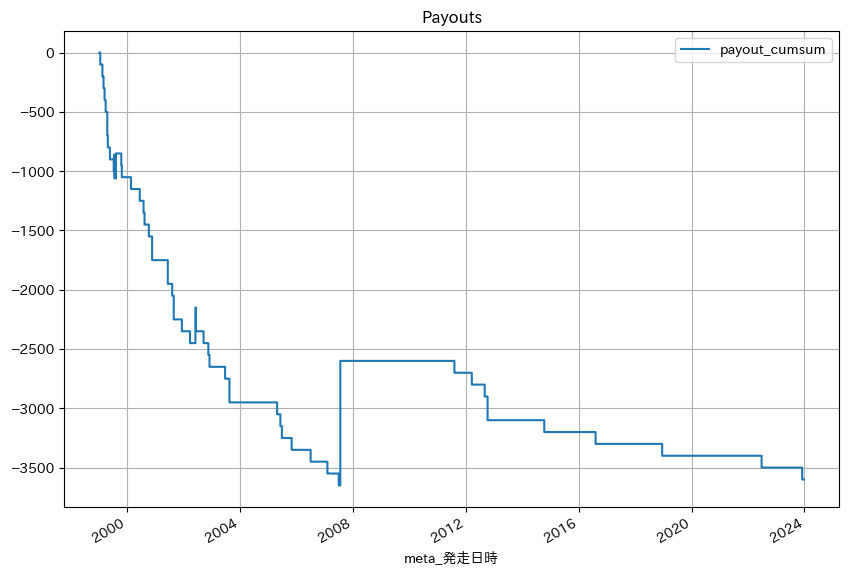

In [35]:
print(f"N bets: {len(bets)}")
ax = payouts.assign(payout_cumsum=lambda x: x["payout"].cumsum()).plot(x="meta_発走日時", y="payout_cumsum", title="Payouts", grid=True, figsize=(10, 7))
# Disable scientific notation on the y-axis
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.show()

In [23]:
bets

[['01001404', '98103089', 0.0],
 ['01002202', '97103747', 0],
 ['01002406', '98104704', 0.0],
 ['01002601', '98107330', 0.0],
 ['01002801', '97104891', 0.0],
 ['01011410', '96107185', 0.0],
 ['01012312', '97102280', 0.0],
 ['01021312', '99110191', 0],
 ['01022208', '99101239', 0.0],
 ['01022610', '99106751', 0.0],
 ['01031501', '01103991', 0.0],
 ['01031509', '99107277', 0.0],
 ['01041106', '01103019', 0.0],
 ['01041309', '99102069', 0],
 ['01041709', '99102595', 0.0],
 ['01042406', '01103098', 0],
 ['01042509', '00103483', 0.0],
 ['01042810', '02107034', 0.0],
 ['01051702', '02104373', 0.0],
 ['01051709', '02106410', 0],
 ['01052109', '01104623', 0.0],
 ['01052311', '01103454', 0.0],
 ['01052406', '02102252', 0],
 ['01052712', '01103221', 0],
 ['01052802', '02100559', 0.0],
 ['01061305', '04110049', 0.0],
 ['01061306', '03104074', 0.0],
 ['01061610', '02100680', 0.0],
 ['01061811', '03102993', 0.0],
 ['01062106', '03100828', 0.0],
 ['01062301', '04100932', 0],
 ['01062402', '03107348'

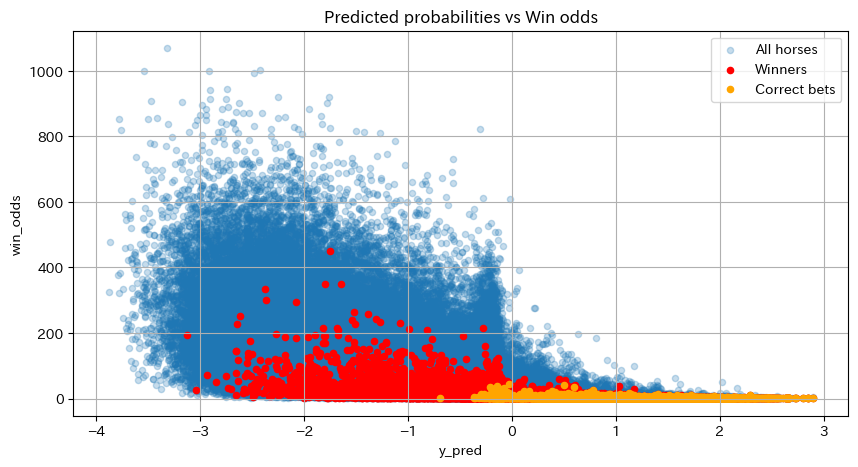

In [29]:
# ax = payouts.y_pred.plot.hist(bins=50, grid=True, figsize=(10, 5));
# ax.set_title("Predicted probabilities distribution");
# ax.set_xlim(0, 10);
fig, ax = plt.subplots(figsize=(10, 5))
payouts.plot.scatter(x="y_pred", y="win_odds", alpha=0.25, ax=ax, label="All horses");
payouts[payouts.position == 1].plot.scatter(x="y_pred", y="win_odds", color="red", ax=ax, label="Winners");
payouts[payouts.payout > 0].plot.scatter(x="y_pred", y="win_odds", color="orange", ax=ax, label="Correct bets");
ax.set_title("Predicted probabilities vs Win odds");
ax.legend()
ax.grid()
plt.show()

<Axes: xlabel='y_pred', ylabel='win_roi'>

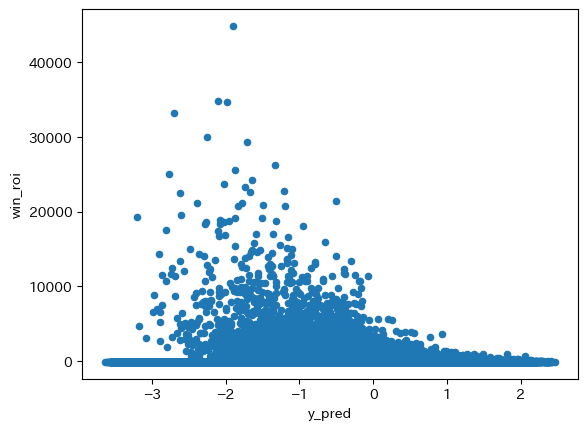

In [127]:
(
    payouts.assign(win=lambda x: x["position"] == 1, place=lambda x: x["position"] <= 3)
    .assign(win_payout_actual=lambda x: (x["win_odds"] - 1) * 100 * x["win"])
    .assign(win_roi=lambda x: x["win_payout_actual"] - 100)
    .assign(place_payout_actual=lambda x: (x["place_odds"] - 1) * 100 * x["place"])
    .assign(place_roi=lambda x: x["place_payout_actual"] - 100)
    .dropna()
    .plot.scatter(x="y_pred", y="win_roi")
)